In [1]:
import tensorflow as tf
import src.infovae as infovae
import numpy as np
import matplotlib.pyplot as plt

## Use a VAE to estimate P(x)

- Does it capture the probability density?
- Are certain digits considered more likely?

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
model_path = '/tmp/infovae/4/infovae.ckpt'
nn = infovae.InfoVAE(12, 16, 4)

In [4]:
x = tf.placeholder(shape=[None, 32, 32, 1], dtype=tf.float32)
x_ = nn(x)

In [5]:
p = tf.exp(-0.5*tf.norm(tf.layers.flatten(nn.z), axis=1))/(tf.sqrt(2*tf.constant(np.pi)))

In [6]:
saver = tf.train.Saver()

## What likelihood does P(x) assign images in our dataset!?

In [7]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    
    batch_x, _ = mnist.train.next_batch(50)
    prob = sess.run(p, feed_dict={x: infovae.InfoVAE.preprocess(batch_x)})

INFO:tensorflow:Restoring parameters from /tmp/infovae/4/infovae.ckpt


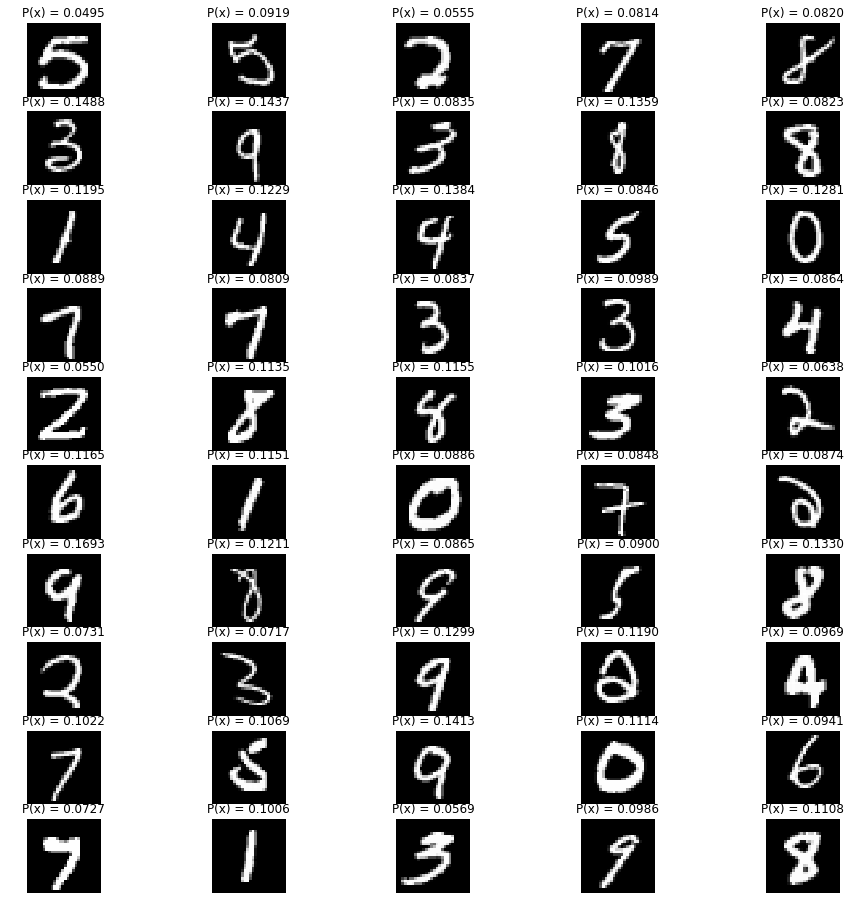

In [8]:
plt.figure(figsize=(16,16))
for i, im in enumerate(batch_x): 
    plt.subplot(10,5,i+1)
    plt.title('P(x) = {:.4f}'.format(prob[i]))
    plt.axis('off')
    plt.imshow(im.reshape((28,28)), interpolation='nearest', cmap='gray')

## What likelihood does P(x) assign noise?

In [9]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    batch_x = np.random.random([50, 28, 28, 1])
    rnd_prob = sess.run(p, feed_dict={x: infovae.InfoVAE.preprocess(batch_x)})

INFO:tensorflow:Restoring parameters from /tmp/infovae/4/infovae.ckpt


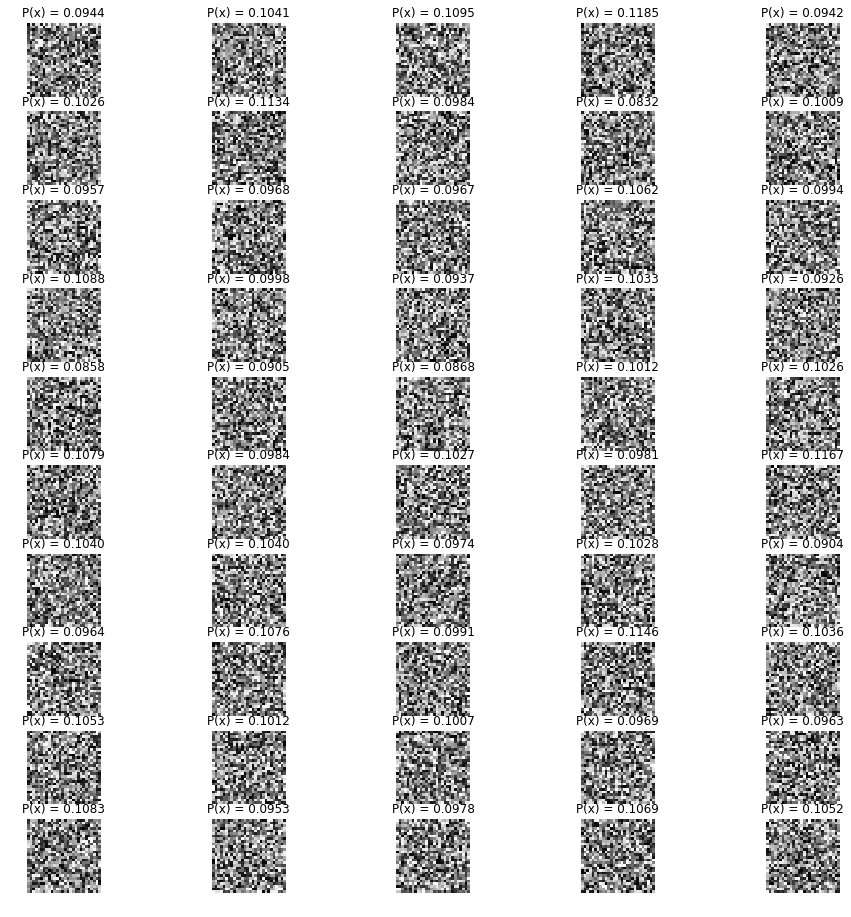

In [10]:
plt.figure(figsize=(16,16))
for i, im in enumerate(batch_x): 
    plt.subplot(10,5,i+1)
    plt.title('P(x) = {:.4f}'.format(rnd_prob[i]))
    plt.axis('off')
    plt.imshow(im.reshape((28,28)), interpolation='nearest', cmap='gray')

INFO:tensorflow:Restoring parameters from /tmp/infovae/4/infovae.ckpt


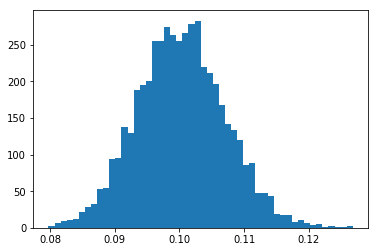

In [11]:
with tf.Session() as sess:
    saver.restore(sess, model_path)

    rnd_prob = np.array([sess.run(p, feed_dict={x: infovae.InfoVAE.preprocess(
        np.random.random([50, 28, 28, 1]))})
                for _ in range(100)])
_ = plt.hist(rnd_prob.reshape(-1), bins=50)

## Which labels are considered more likely?

In [12]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    
    for i in range(1000):
        batch_x, batch_l = mnist.train.next_batch(50)
    
        prob = sess.run(p, feed_dict={x: infovae.InfoVAE.preprocess(batch_x)})

        if i == 0:
            labels, probs = batch_l, prob
        else:
            labels = np.hstack([labels, batch_l])
            probs = np.hstack([probs, prob])
            
    

INFO:tensorflow:Restoring parameters from /tmp/infovae/4/infovae.ckpt


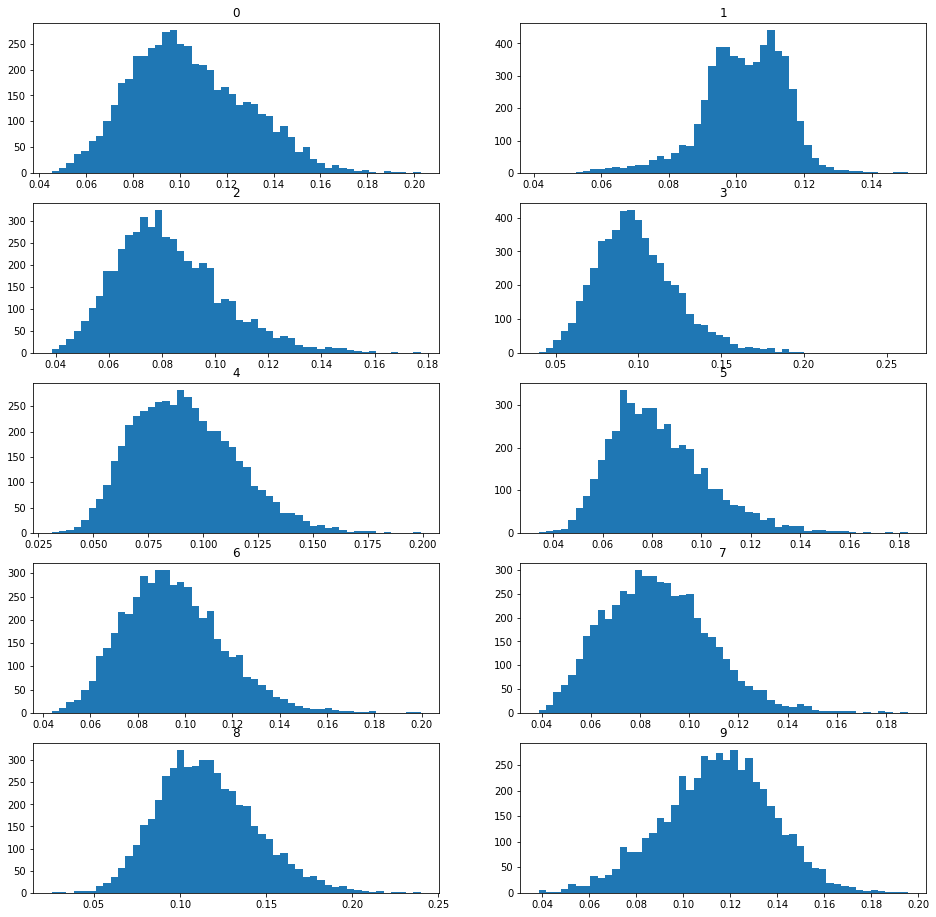

In [13]:
plt.figure(figsize=(16,16))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.title('{}'.format(i))
    _ = plt.hist(probs[labels==i], bins=50)

## What does it look like if we maximise P(x)?

Do grad descent on a random image to maximise P(x).

In [14]:
with tf.variable_scope('x', reuse=tf.AUTO_REUSE) as scope:
    x = tf.get_variable(name='image', shape=[1, 32,32,1], dtype=tf.float32)
y = nn(x)
p = tf.exp(-0.5*tf.norm(tf.layers.flatten(nn.z), axis=1))/(tf.sqrt(2*tf.constant(np.pi)))
loss = -tf.reduce_mean(p)  # maximise p
print(loss)
train_step = tf.train.AdamOptimizer().minimize(loss, var_list=[x])

Tensor("Neg:0", shape=(), dtype=float32)


INFO:tensorflow:Restoring parameters from /tmp/infovae/4/infovae.ckpt


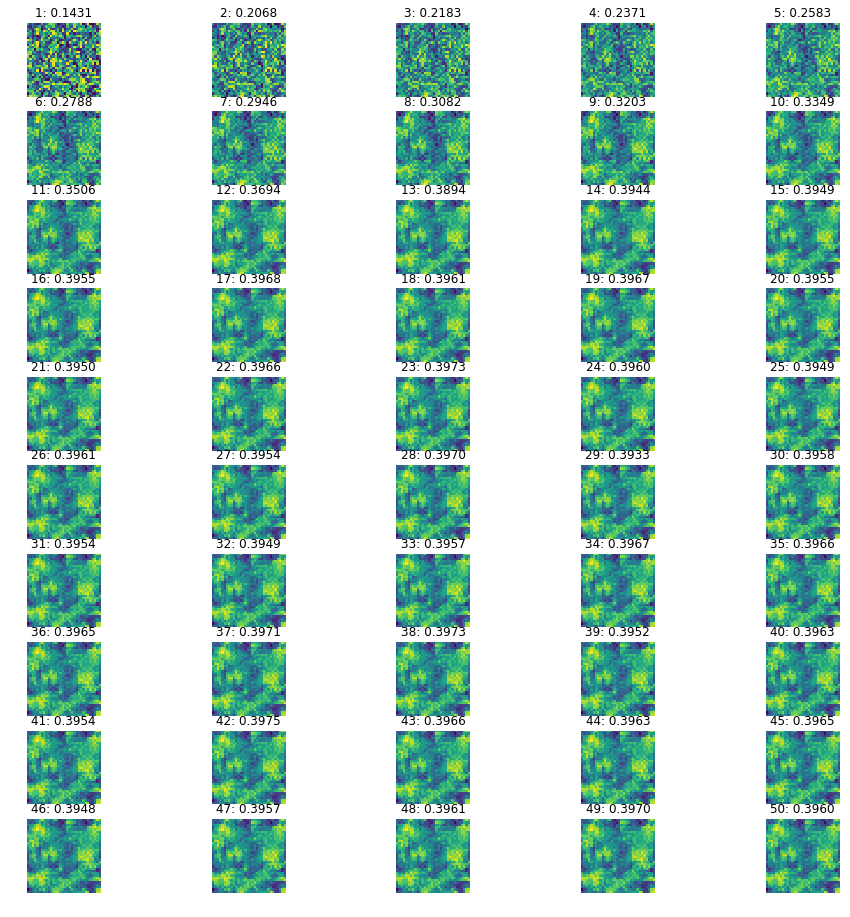

In [15]:
count = 0
plt.figure(figsize=(16,16))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path)
    
    for i in range(1000):
        sess.run(train_step)
        X, P = sess.run([x, p])
        
        if i % 20 == 0:
            count+=1
            plt.subplot(10,5,count)
            plt.title('{}: {:.4f}'.format(count, P[0]))
            plt.imshow(X[0].reshape((32,32)))
            plt.axis('off')